In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree,fcluster
from sklearn.preprocessing import StandardScaler

In [228]:
sm = pd.read_csv('C:/Users/rayad/OneDrive/Desktop/Introduction to ML/Part 2/social_marketing.csv')
sm['chatter']=sm['uncategorized']+sm['chatter'] #we merge bith chatter and unorganized into one columns, chatter, and drop the uncategorized one 
sm.drop(columns = 'uncategorized',inplace = True)

Text(0.5, 1.0, 'Histogram of the number of tweets')

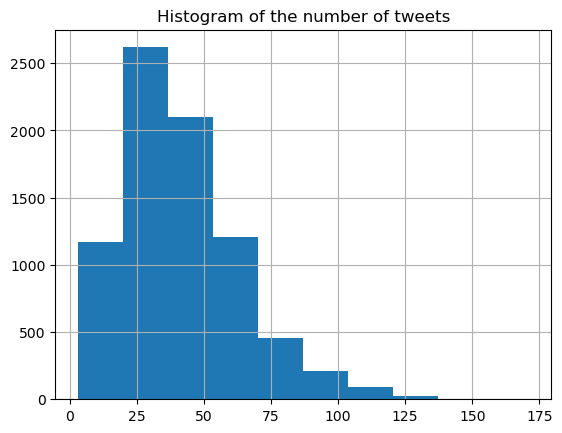

In [229]:
#to check if there are certain people tweeting more than the others 
row_sum = sm.set_index('Unnamed: 0').sum(axis=1)
row_sum.hist() 
market = sm.set_index('Unnamed: 0')
plt.title("Histogram of the number of tweets")

We find that there a few people who tweet a lot (>75) and then a few who tweet less than the mean tweets. Despite seeing the skewness, we decided not to take a the % of tweets in a particular category by a consumer becuase a single tweet can be a part of multiple categories, and might therefore, not give the right value 

Looking at the type of tweets : 

Text(0.5, 1.0, 'Average Tweets')

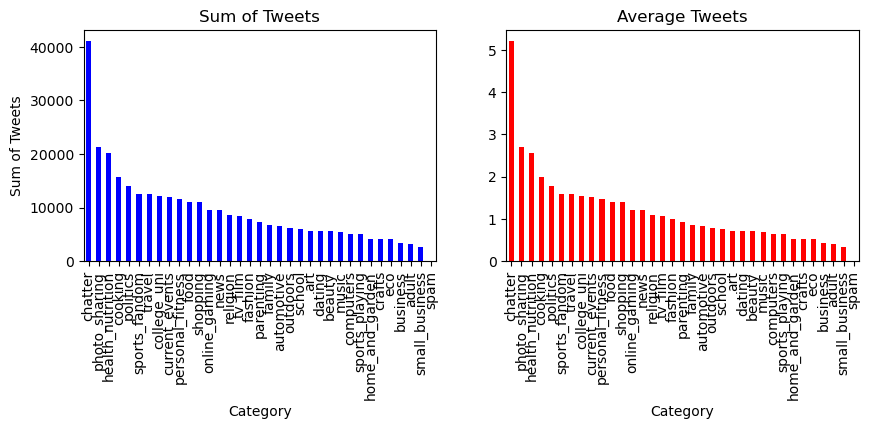

In [232]:
#looking at the overall tweets : 
p1 = sm.iloc[:,1:].sum().sort_values(ascending = False)
p2 = sm.iloc[:,1:].mean().sort_values(ascending = False)
figure, axes = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = False, figsize=(10, 3))

p1.plot(ax=axes[0], title="Series 1", color="blue",linestyle='None',kind ='bar')
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Sum of Tweets")
axes[0].set_title("Sum of Tweets")

p2.plot(ax=axes[1], title="Series 2", color="red",linestyle='None',kind ='bar')
axes[1].set_xlabel("Category")
axes[1].set_title("Average Tweets")

Most of the tweets seem to be chatter or uncategorised tweets. Let us try to keep chatter and then form different clusters

## Kmeans++ with chatter

In [235]:
sm_cleaned = sm.set_index('Unnamed: 0')
sm_cleaned

,chatter,current_events,travel,photo_sharing,tv_film,sports_fandom,politics,food,family,home_and_garden,...,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business,spam,adult
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
hmjoe4g3k,4,0,2,2,1,1,0,4,1,2,...,1,0,1,1,0,11,0,0,0,0
clk1m5w8s,4,3,2,1,1,4,1,2,2,1,...,0,0,0,1,4,0,0,0,0,0
jcsovtak3,7,3,4,3,5,0,2,1,1,1,...,0,1,0,1,0,0,1,0,0,0
3oeb4hiln,1,5,2,2,1,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
fd75x1vgk,6,2,0,6,0,0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
y3ijoqfgd,5,4,2,1,1,0,1,0,0,0,...,0,0,0,0,0,2,0,0,0,0
n6gud4ext,9,3,2,4,1,0,4,1,3,0,...,0,1,0,1,0,5,0,1,0,0
f71rt6cyg,3,2,1,1,4,1,2,1,0,3,...,1,0,1,1,0,6,1,0,0,0


In [236]:
#create an instance of the scaler to scale the data 
scaler = StandardScaler()
sm_cleaned_scaled = scaler.fit_transform(sm_cleaned)
sm_cleaned_scaled = pd.DataFrame(sm_cleaned_scaled,columns=sm_cleaned.columns)
sm_cleaned_scaled

,chatter,current_events,travel,photo_sharing,tv_film,sports_fandom,politics,food,family,home_and_garden,...,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business,spam,adult
0,-0.326531,-1.202909,0.181587,-0.255105,-0.042375,-0.274906,-0.590128,1.465837,0.120207,2.008187,...,-0.049829,-0.531060,0.051912,0.162234,-0.646111,3.965726,-0.545084,-0.544138,-0.077692,-0.222424
1,-0.326531,1.161512,0.181587,-0.621226,-0.042375,1.113481,-0.260196,0.339358,1.003217,0.650680,...,-0.572101,-0.531060,-0.608040,0.162234,2.720372,-0.607904,-0.545084,-0.544138,-0.077692,-0.222424
2,0.481882,1.161512,1.056713,0.111016,2.369184,-0.737702,0.069737,-0.223881,0.120207,0.650680,...,-0.572101,0.222055,-0.608040,0.162234,-0.646111,-0.607904,0.001874,-0.544138,-0.077692,-0.222424
3,-1.134944,2.737792,0.181587,-0.255105,-0.042375,-0.737702,-0.260196,-0.787120,0.120207,-0.706827,...,-0.572101,0.222055,-0.608040,-0.398859,-0.646111,-0.607904,-0.545084,-0.544138,-0.077692,-0.222424
4,0.212411,0.373372,-0.693539,1.209379,-0.645265,-0.737702,0.069737,-0.787120,0.120207,-0.706827,...,-0.572101,-0.531060,-0.608040,-0.398859,-0.646111,-0.607904,-0.545084,1.073703,-0.077692,-0.222424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7877,-0.057060,1.949652,0.181587,-0.621226,-0.042375,-0.737702,-0.260196,-0.787120,-0.762803,-0.706827,...,-0.572101,-0.531060,-0.608040,-0.398859,-0.646111,0.223665,-0.545084,-0.544138,-0.077692,-0.222424
7878,1.020824,1.161512,0.181587,0.477137,-0.042375,-0.737702,0.729602,-0.223881,1.886227,-0.706827,...,-0.572101,0.222055,-0.608040,0.162234,-0.646111,1.471019,-0.545084,1.073703,-0.077692,-0.222424
7879,-0.596002,0.373372,-0.255976,-0.621226,1.766294,-0.274906,0.069737,-0.223881,-0.762803,3.365694,...,-0.049829,-0.531060,0.051912,0.162234,-0.646111,1.886803,0.001874,-0.544138,-0.077692,-0.222424
7880,-0.596002,0.373372,-0.693539,0.477137,-0.645265,-0.274906,-0.260196,-0.223881,0.120207,-0.706827,...,-0.572101,-0.531060,0.051912,-0.398859,-0.646111,-0.192120,0.001874,-0.544138,11.929560,6.395298


In [237]:
ssew = []
ch_index = [] 
for i in range(1,20):
    kmeans = KMeans(n_clusters = i,random_state = 1)
    kmeans.fit(sm_cleaned_scaled)
    ssew.append(kmeans.inertia_)
    if(i!=1):
        labels = kmeans.labels_
        ch_index.append(calinski_harabasz_score(sm_cleaned_scaled, labels))

Text(0.5, 1.0, 'CH Index')

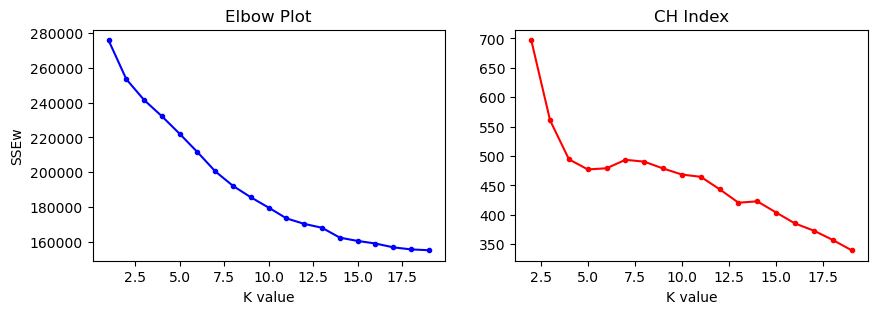

In [238]:
figure, axes = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = False, figsize=(10, 3))

axes[0].plot(range(1,20),ssew, color="blue",marker ='.')
axes[0].set_xlabel("K value")
axes[0].set_ylabel("SSEw")
axes[0].set_title("Elbow Plot")

axes[1].plot(range(2,20),ch_index, color="red",marker ='.')
axes[1].set_xlabel("K value")
axes[1].set_title("CH Index")
axes[1].set_title("CH Index")

In [239]:
#using k=4 to get 4 clusters - has high CH index and a relatively low SSEw
kmeans = KMeans(n_clusters = 4,init='k-means++', n_init=10, random_state = 1)
kmeans.fit(sm_cleaned_scaled)
sm_cleaned['kmeans_label']=kmeans.labels_

In [240]:
#learning about clusters 
cluster0 = sm_cleaned[sm_cleaned['kmeans_label']==0].drop(columns = 'kmeans_label')
cluster1 = sm_cleaned[sm_cleaned['kmeans_label']==1].drop(columns = 'kmeans_label')
cluster2 = sm_cleaned[sm_cleaned['kmeans_label']==2].drop(columns = 'kmeans_label')
cluster3 = sm_cleaned[sm_cleaned['kmeans_label']==3].drop(columns = 'kmeans_label')

p1=cluster0.sum().sort_values(ascending = False)[:8]
p2=cluster0.mean().sort_values(ascending = False)[:8]

p3=cluster1.sum().sort_values(ascending = False)[:8]
p4=cluster1.mean().sort_values(ascending = False)[:8]

p5=cluster2.sum().sort_values(ascending = False)[:8]
p6=cluster2.mean().sort_values(ascending = False)[:8]

p7=cluster3.sum().sort_values(ascending = False)[:8]
p8=cluster3.mean().sort_values(ascending = False)[:8]

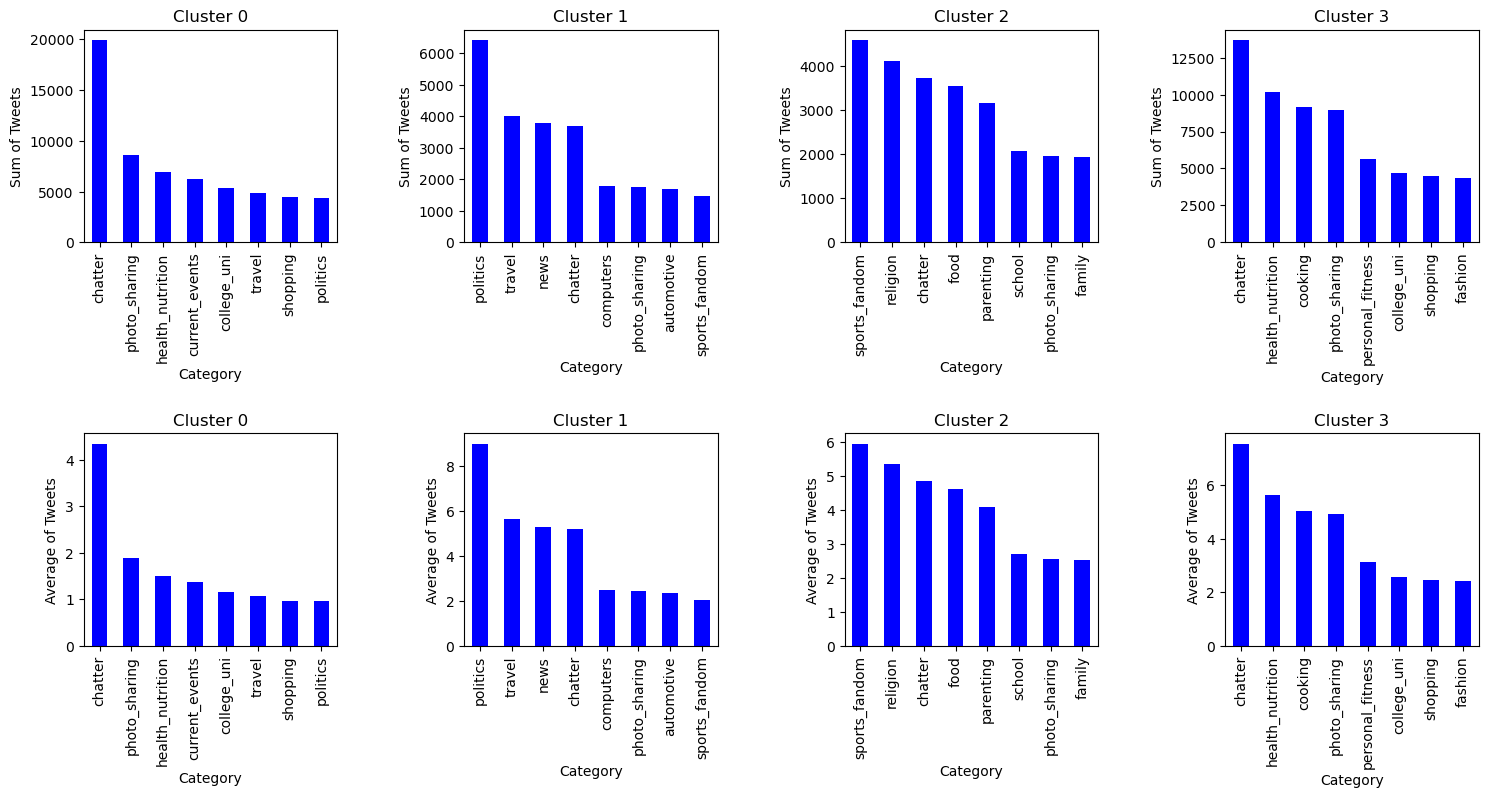

In [241]:
figure, axes = plt.subplots(nrows = 2, ncols = 4, sharex = False, sharey = False, figsize=(18, 8))

p1.plot(ax=axes[0, 0], title="Cluster 0", color="blue",linestyle='None',kind ='bar')
axes[0, 0].set_xlabel("Category")
axes[0, 0].set_ylabel("Sum of Tweets")
p2.plot(ax=axes[1, 0], title="Cluster 0", color="blue",linestyle='None',kind ='bar')
axes[1, 0].set_xlabel("Category")
axes[1, 0].set_ylabel("Average of Tweets")

p3.plot(ax=axes[0, 1], title="Cluster 1", color="blue",linestyle='None',kind ='bar')
axes[0, 1].set_xlabel("Category")
axes[0, 1].set_ylabel("Sum of Tweets")
p4.plot(ax=axes[1, 1], title="Cluster 1", color="blue",linestyle='None',kind ='bar')
axes[1, 1].set_xlabel("Category")
axes[1, 1].set_ylabel("Average of Tweets")

p5.plot(ax=axes[0, 2], title="Cluster 2", color="blue",linestyle='None',kind ='bar')
axes[0, 2].set_xlabel("Category")
axes[0, 2].set_ylabel("Sum of Tweets")
p6.plot(ax=axes[1, 2], title="Cluster 2", color="blue",linestyle='None',kind ='bar')
axes[1, 2].set_xlabel("Category")
axes[1, 2].set_ylabel("Average of Tweets")

p7.plot(ax=axes[0, 3], title="Cluster 3", color="blue",linestyle='None',kind ='bar')
axes[0, 3].set_xlabel("Category")
axes[0, 3].set_ylabel("Sum of Tweets")
p8.plot(ax=axes[1, 3], title="Cluster 3", color="blue",linestyle='None',kind ='bar')
axes[1, 3].set_xlabel("Category")
axes[1, 3].set_ylabel("Average of Tweets")

plt.subplots_adjust(hspace=0.9, wspace = 0.5)

We see that chatter shows up in top 4 in all 4 clusters (top category in 2 of them) - but chatter as a category, is not giving us much insight into identifying the customer niches segments. Let us try running them without chatter 

## Kmeans++ without chatter

In [244]:
scaler = StandardScaler()
sm_cleaned2 = sm_cleaned.drop(columns = ['chatter','kmeans_label'])
sm_cleaned_scaled2 = scaler.fit_transform(sm_cleaned2)
sm_cleaned_scaled2 = pd.DataFrame(sm_cleaned_scaled2,columns=sm_cleaned2.columns)
sm_cleaned_scaled2

,current_events,travel,photo_sharing,tv_film,sports_fandom,politics,food,family,home_and_garden,music,...,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business,spam,adult
0,-1.202909,0.181587,-0.255105,-0.042375,-0.274906,-0.590128,1.465837,0.120207,2.008187,-0.659517,...,-0.049829,-0.531060,0.051912,0.162234,-0.646111,3.965726,-0.545084,-0.544138,-0.077692,-0.222424
1,1.161512,0.181587,-0.621226,-0.042375,1.113481,-0.260196,0.339358,1.003217,0.650680,-0.659517,...,-0.572101,-0.531060,-0.608040,0.162234,2.720372,-0.607904,-0.545084,-0.544138,-0.077692,-0.222424
2,1.161512,1.056713,0.111016,2.369184,-0.737702,0.069737,-0.223881,0.120207,0.650680,0.311404,...,-0.572101,0.222055,-0.608040,0.162234,-0.646111,-0.607904,0.001874,-0.544138,-0.077692,-0.222424
3,2.737792,0.181587,-0.255105,-0.042375,-0.737702,-0.260196,-0.787120,0.120207,-0.706827,-0.659517,...,-0.572101,0.222055,-0.608040,-0.398859,-0.646111,-0.607904,-0.545084,-0.544138,-0.077692,-0.222424
4,0.373372,-0.693539,1.209379,-0.645265,-0.737702,0.069737,-0.787120,0.120207,-0.706827,-0.659517,...,-0.572101,-0.531060,-0.608040,-0.398859,-0.646111,-0.607904,-0.545084,1.073703,-0.077692,-0.222424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7877,1.949652,0.181587,-0.621226,-0.042375,-0.737702,-0.260196,-0.787120,-0.762803,-0.706827,-0.659517,...,-0.572101,-0.531060,-0.608040,-0.398859,-0.646111,0.223665,-0.545084,-0.544138,-0.077692,-0.222424
7878,1.161512,0.181587,0.477137,-0.042375,-0.737702,0.729602,-0.223881,1.886227,-0.706827,2.253247,...,-0.572101,0.222055,-0.608040,0.162234,-0.646111,1.471019,-0.545084,1.073703,-0.077692,-0.222424
7879,0.373372,-0.255976,-0.621226,1.766294,-0.274906,0.069737,-0.223881,-0.762803,3.365694,-0.659517,...,-0.049829,-0.531060,0.051912,0.162234,-0.646111,1.886803,0.001874,-0.544138,-0.077692,-0.222424
7880,0.373372,-0.693539,0.477137,-0.645265,-0.274906,-0.260196,-0.223881,0.120207,-0.706827,-0.659517,...,-0.572101,-0.531060,0.051912,-0.398859,-0.646111,-0.192120,0.001874,-0.544138,11.929560,6.395298


In [245]:
ssew = []
ch_index = [] 
for i in range(1,20):
    kmeans = KMeans(n_clusters = i,random_state = 1)
    kmeans.fit(sm_cleaned_scaled2)
    ssew.append(kmeans.inertia_)
    if(i!=1):
        labels = kmeans.labels_
        ch_index.append(calinski_harabasz_score(sm_cleaned_scaled2, labels))

Text(0.5, 1.0, 'CH Index')

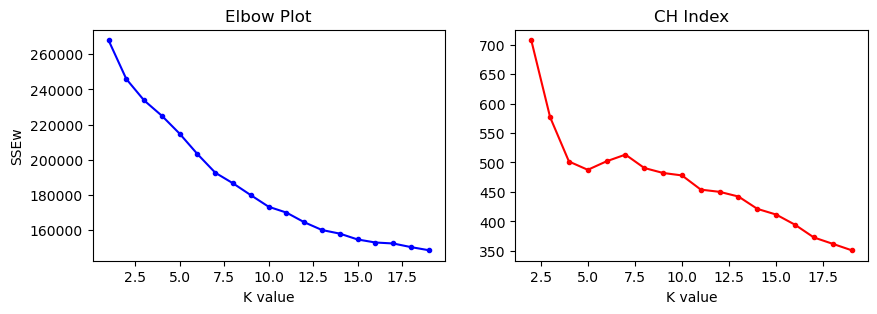

In [246]:
figure, axes = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = False, figsize=(10, 3))

axes[0].plot(range(1,20),ssew, color="blue",marker ='.')
axes[0].set_xlabel("K value")
axes[0].set_ylabel("SSEw")
axes[0].set_title("Elbow Plot")

axes[1].plot(range(2,20),ch_index, color="red",marker ='.')
axes[1].set_xlabel("K value")
axes[1].set_title("CH Index")
axes[1].set_title("CH Index")

Although 7 seems to have a good CH index, it is a lot of clusters to deal with in real world. The next best option is 4,just like the initial trial

In [248]:
kmeans = KMeans(n_clusters = 4,init='k-means++', n_init=10, random_state = 1)
kmeans.fit(sm_cleaned_scaled2)
sm_cleaned2['kmeans_label']=kmeans.labels_

In [249]:
#learning about clusters 
cluster0 = sm_cleaned2[sm_cleaned2['kmeans_label']==0].drop(columns = 'kmeans_label')
cluster1 = sm_cleaned2[sm_cleaned2['kmeans_label']==1].drop(columns = 'kmeans_label')
cluster2 = sm_cleaned2[sm_cleaned2['kmeans_label']==2].drop(columns = 'kmeans_label')
cluster3 = sm_cleaned2[sm_cleaned2['kmeans_label']==3].drop(columns = 'kmeans_label')

p1=cluster0.sum().sort_values(ascending = False)[:10]
p2=cluster0.mean().sort_values(ascending = False)[:10]

p3=cluster1.sum().sort_values(ascending = False)[:10]
p4=cluster1.mean().sort_values(ascending = False)[:10]

p5=cluster2.sum().sort_values(ascending = False)[:10]
p6=cluster2.mean().sort_values(ascending = False)[:10]

p7=cluster3.sum().sort_values(ascending = False)[:10]
p8=cluster3.mean().sort_values(ascending = False)[:10]

Number of points in Cluster 0 = 4872
Number of points in Cluster 1 = 715
Number of points in Cluster 2 = 1503
Number of points in Cluster 3 = 792


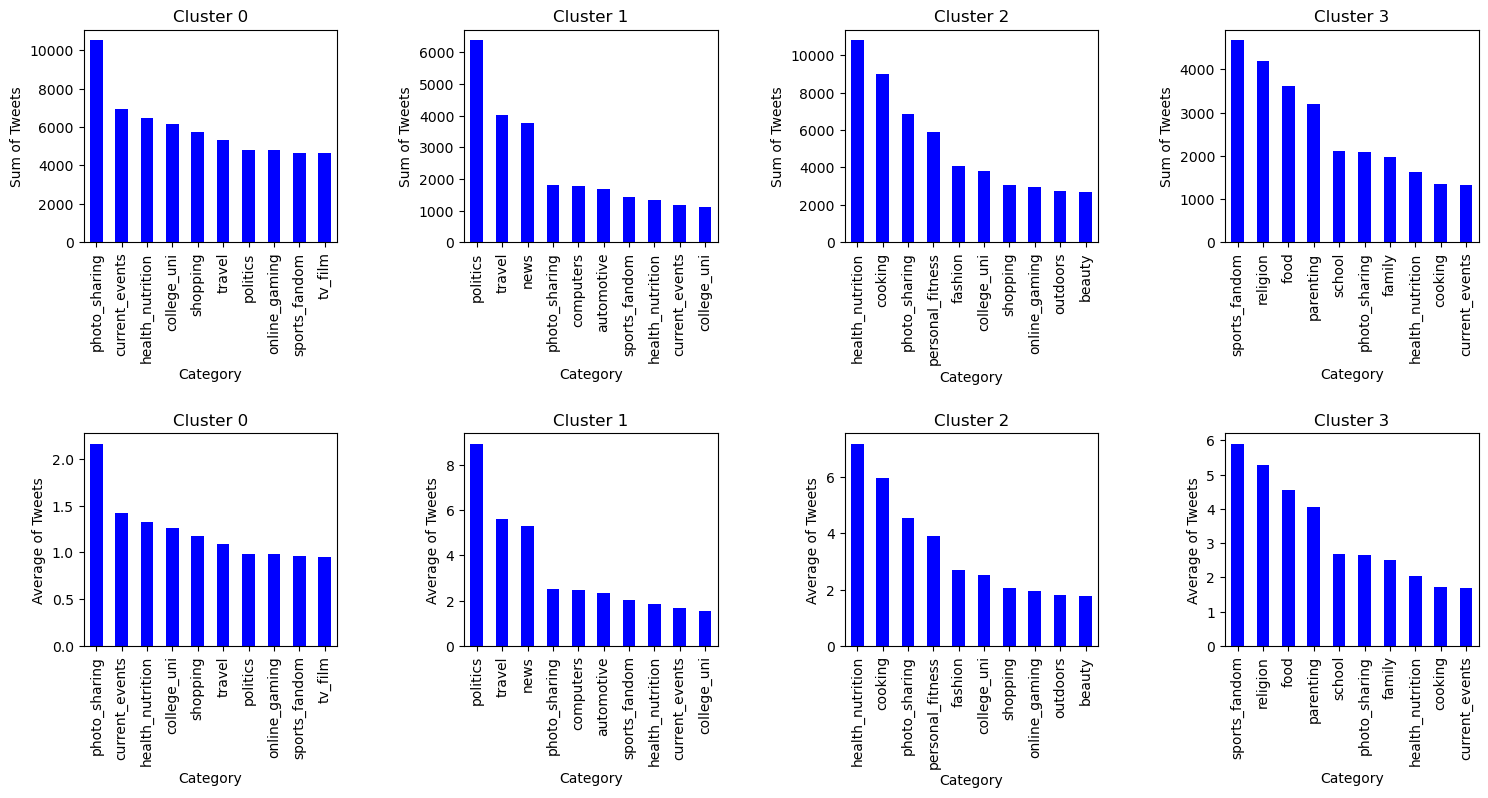

In [250]:
figure, axes = plt.subplots(nrows = 2, ncols = 4, sharex = False, sharey = False, figsize=(18, 8))

p1.plot(ax=axes[0, 0], title="Cluster 0", color="blue",linestyle='None',kind ='bar')
axes[0, 0].set_xlabel("Category")
axes[0, 0].set_ylabel("Sum of Tweets")
p2.plot(ax=axes[1, 0], title="Cluster 0", color="blue",linestyle='None',kind ='bar')
axes[1, 0].set_xlabel("Category")
axes[1, 0].set_ylabel("Average of Tweets")

p3.plot(ax=axes[0, 1], title="Cluster 1", color="blue",linestyle='None',kind ='bar')
axes[0, 1].set_xlabel("Category")
axes[0, 1].set_ylabel("Sum of Tweets")
p4.plot(ax=axes[1, 1], title="Cluster 1", color="blue",linestyle='None',kind ='bar')
axes[1, 1].set_xlabel("Category")
axes[1, 1].set_ylabel("Average of Tweets")

p5.plot(ax=axes[0, 2], title="Cluster 2", color="blue",linestyle='None',kind ='bar')
axes[0, 2].set_xlabel("Category")
axes[0, 2].set_ylabel("Sum of Tweets")
p6.plot(ax=axes[1, 2], title="Cluster 2", color="blue",linestyle='None',kind ='bar')
axes[1, 2].set_xlabel("Category")
axes[1, 2].set_ylabel("Average of Tweets")

p7.plot(ax=axes[0, 3], title="Cluster 3", color="blue",linestyle='None',kind ='bar')
axes[0, 3].set_xlabel("Category")
axes[0, 3].set_ylabel("Sum of Tweets")
p8.plot(ax=axes[1, 3], title="Cluster 3", color="blue",linestyle='None',kind ='bar')
axes[1, 3].set_xlabel("Category")
axes[1, 3].set_ylabel("Average of Tweets")

plt.subplots_adjust(hspace=0.9, wspace = 0.5)

print("Number of points in Cluster 0 =",len(cluster0))
print("Number of points in Cluster 1 =",len(cluster1))
print("Number of points in Cluster 2 =",len(cluster2))
print("Number of points in Cluster 3 =",len(cluster3))

**Cluster Descriptions : Notice health_nutrition comes up as a important category in all of them**<br>
**Cluster 0**: Let's call this cluster **College and University students- Social Enthusiasts"**. With about 61%, this is the biggest cluster. They love photo sharing, current events, colleges and universities, shopping, travel, online gaming, sports, movies. Thier spending power might not be very high but they can be a very vital segment of the market for a health product - for its sales as well as marketing. <br>
**Cluster 1** : Let's call this one **Young adults - "Politically Engaged Travelers**, kind of new to the workforce- accounting for just 8% of the total followers sample. They like to talk about politics, travel, news, sports , current events. They might be a small segment, but they would be having good spending power, coupled with the visibility for our product we talked about in the earlier segment<br>
**Cluster 2** : These account for about 17% of our total followers. They are intrested in shopping, cooking, fashion, fitness, beauty and outdoors. Let's call them **Health & Lifestyle Gurus**. They focus on a mix of health as well of lifestyle and fashion<br>
**Cluster 3** : These 9 % are our **Community-Oriented Fans**.This cluster shows a strong interest in sports fandom, religion, and family-related topics. They seem to be deeply involved in their communities, whether through sports, religious activities, or family life. They have a strong connection to both recreational and community-focused activities.<br>
Note : We also tried clustering using just 3 clusters- there seemed to be some imbalance - with 1 cluser accounting for just spams and salcious content, the other 2 having interests in politics and travel and religion. We chose 4 based on the ch index, and optimal number of clsters that can be used to tailor the marketing campaigns

In [252]:
sm_cleaned = sm_cleaned.drop(columns = 'kmeans_label')

## Trying Agglomerative clustering

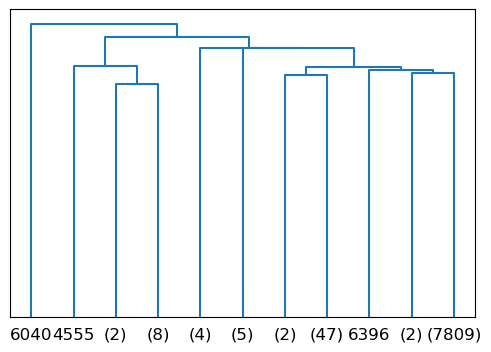

In [254]:
# Perform hierarchical/agglomerative clustering
Z = linkage(sm_cleaned_scaled, method='average')

# Plot the dendrogram
plt.figure(figsize=(6, 4))
dendrogram(Z,truncate_mode='lastp', p=11,show_leaf_counts = True)
plt.tick_params(left=False, labelleft=False)  

Descrirption of the dendrogram : We are just looking at the last 11 merges of the dendrogram<br>
The numbers within brackets represent the number of points in that cluster and the ones not in parenthesis are the indices of row elemets part of that cluster<br>
The tree looks heavily imbalanced, with the first few branches just have 1 or 2 or 5 points and the last one having about 85% of the data. Agglomerative clusterring doesn't seem to be performing very well with our data <br>
Kmeans ++ with does the better job

## TSNE with chatter

In [257]:
sm_cleaned
scaler = StandardScaler()
sm_cleaned3 = sm_cleaned.drop(columns = ['chatter'])
sm_cleaned_scaled3 = scaler.fit_transform(sm_cleaned3)
sm_cleaned_scaled3 = pd.DataFrame(sm_cleaned_scaled3,columns=sm_cleaned3.columns)
sm_cleaned_scaled3

,current_events,travel,photo_sharing,tv_film,sports_fandom,politics,food,family,home_and_garden,music,...,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business,spam,adult
0,-1.202909,0.181587,-0.255105,-0.042375,-0.274906,-0.590128,1.465837,0.120207,2.008187,-0.659517,...,-0.049829,-0.531060,0.051912,0.162234,-0.646111,3.965726,-0.545084,-0.544138,-0.077692,-0.222424
1,1.161512,0.181587,-0.621226,-0.042375,1.113481,-0.260196,0.339358,1.003217,0.650680,-0.659517,...,-0.572101,-0.531060,-0.608040,0.162234,2.720372,-0.607904,-0.545084,-0.544138,-0.077692,-0.222424
2,1.161512,1.056713,0.111016,2.369184,-0.737702,0.069737,-0.223881,0.120207,0.650680,0.311404,...,-0.572101,0.222055,-0.608040,0.162234,-0.646111,-0.607904,0.001874,-0.544138,-0.077692,-0.222424
3,2.737792,0.181587,-0.255105,-0.042375,-0.737702,-0.260196,-0.787120,0.120207,-0.706827,-0.659517,...,-0.572101,0.222055,-0.608040,-0.398859,-0.646111,-0.607904,-0.545084,-0.544138,-0.077692,-0.222424
4,0.373372,-0.693539,1.209379,-0.645265,-0.737702,0.069737,-0.787120,0.120207,-0.706827,-0.659517,...,-0.572101,-0.531060,-0.608040,-0.398859,-0.646111,-0.607904,-0.545084,1.073703,-0.077692,-0.222424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7877,1.949652,0.181587,-0.621226,-0.042375,-0.737702,-0.260196,-0.787120,-0.762803,-0.706827,-0.659517,...,-0.572101,-0.531060,-0.608040,-0.398859,-0.646111,0.223665,-0.545084,-0.544138,-0.077692,-0.222424
7878,1.161512,0.181587,0.477137,-0.042375,-0.737702,0.729602,-0.223881,1.886227,-0.706827,2.253247,...,-0.572101,0.222055,-0.608040,0.162234,-0.646111,1.471019,-0.545084,1.073703,-0.077692,-0.222424
7879,0.373372,-0.255976,-0.621226,1.766294,-0.274906,0.069737,-0.223881,-0.762803,3.365694,-0.659517,...,-0.049829,-0.531060,0.051912,0.162234,-0.646111,1.886803,0.001874,-0.544138,-0.077692,-0.222424
7880,0.373372,-0.693539,0.477137,-0.645265,-0.274906,-0.260196,-0.223881,0.120207,-0.706827,-0.659517,...,-0.572101,-0.531060,0.051912,-0.398859,-0.646111,-0.192120,0.001874,-0.544138,11.929560,6.395298


In [258]:
from sklearn.manifold import TSNE

# t-SNE with 2 dimensions
tsne = TSNE(n_components=2, random_state=1)
tsne_results = tsne.fit_transform(sm_cleaned_scaled3)
data_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

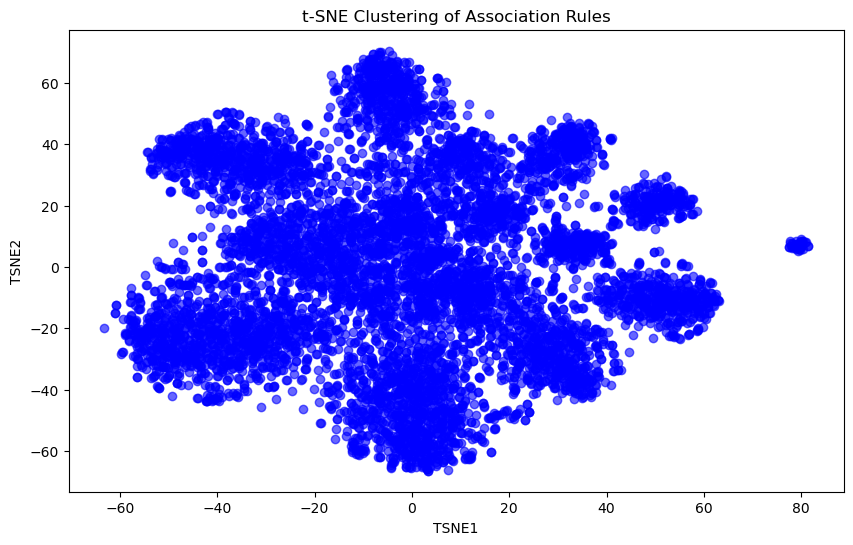

In [259]:
import matplotlib.pyplot as plt

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(data_tsne['TSNE1'], data_tsne['TSNE2'], c='blue', alpha=0.6)
plt.title('t-SNE Clustering of Association Rules')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

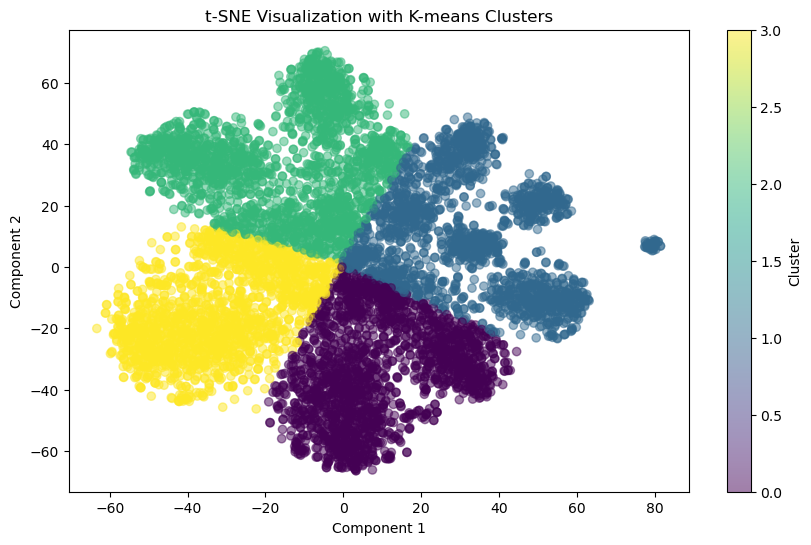

In [260]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4,init='k-means++', n_init=10, random_state=0)  # Change number of clusters as needed
clusters = kmeans.fit_predict(data_tsne)

# Add cluster labels to the t-SNE DataFrame
data_tsne['Cluster'] = clusters

# Plot the t-SNE result with clusters
plt.figure(figsize=(10, 6))
plt.scatter(data_tsne['TSNE1'], data_tsne['TSNE2'], c=data_tsne['Cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.title('t-SNE Visualization with K-means Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [261]:
sm_cleaned4 = sm_cleaned.reset_index()
sm_cleaned4['tsne_clusters']=data_tsne['Cluster']
sm_cleaned4.set_index('Unnamed: 0', inplace = True)

In [262]:
#learning about clusters 
cluster0 = sm_cleaned4[sm_cleaned4['tsne_clusters']==0].drop(columns = 'tsne_clusters')
cluster1 = sm_cleaned4[sm_cleaned4['tsne_clusters']==1].drop(columns = 'tsne_clusters')
cluster2 = sm_cleaned4[sm_cleaned4['tsne_clusters']==2].drop(columns = 'tsne_clusters')
cluster3 = sm_cleaned4[sm_cleaned4['tsne_clusters']==3].drop(columns = 'tsne_clusters')

p1=cluster0.sum().sort_values(ascending = False)[:10]
p2=cluster0.mean().sort_values(ascending = False)[:10]

p3=cluster1.sum().sort_values(ascending = False)[:10]
p4=cluster1.mean().sort_values(ascending = False)[:10]

p5=cluster2.sum().sort_values(ascending = False)[:10]
p6=cluster2.mean().sort_values(ascending = False)[:10]

p7=cluster3.sum().sort_values(ascending = False)[:10]
p8=cluster3.mean().sort_values(ascending = False)[:10]

Number of points in Cluster 0 = 2006
Number of points in Cluster 1 = 1957
Number of points in Cluster 2 = 2147
Number of points in Cluster 3 = 1772


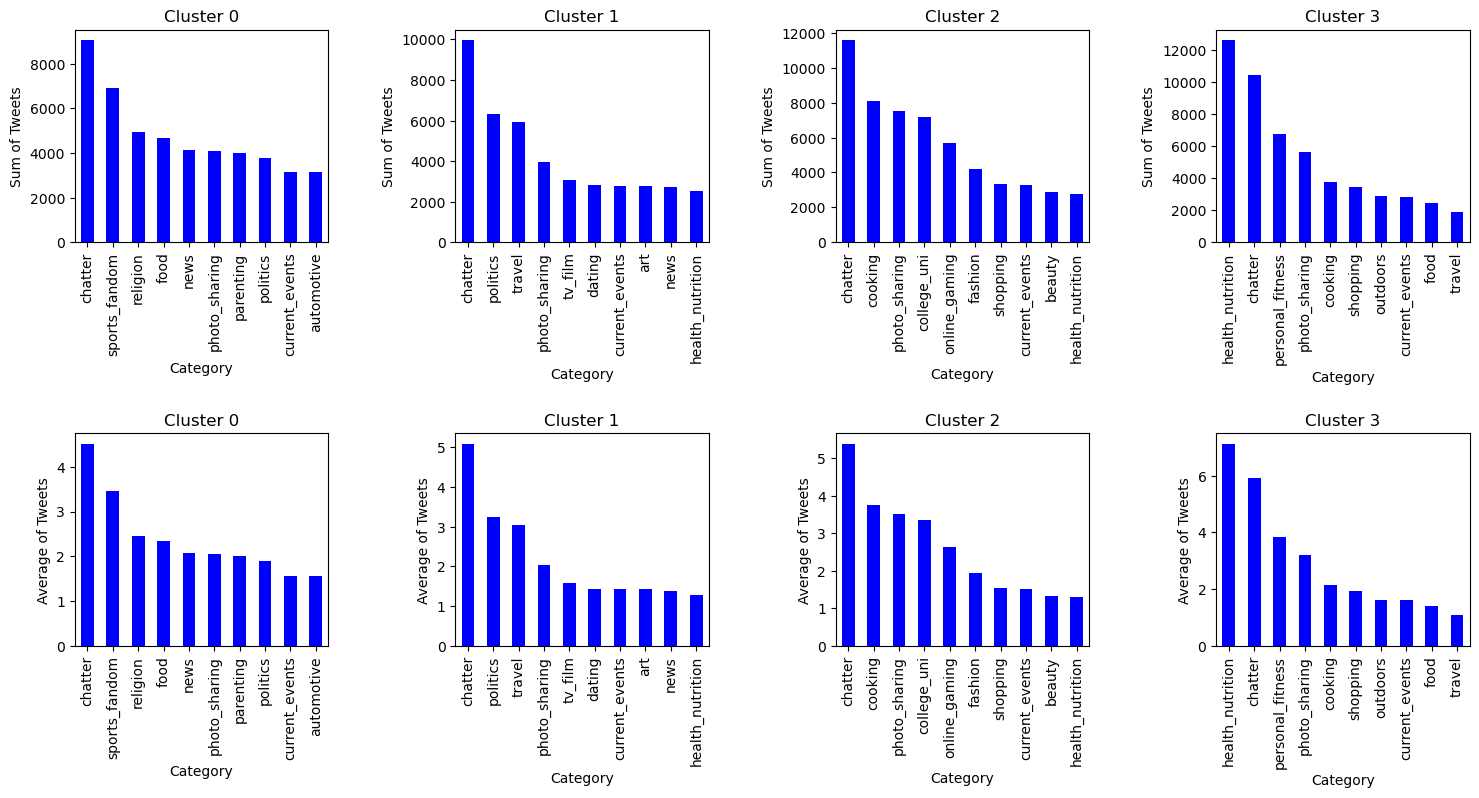

In [263]:
figure, axes = plt.subplots(nrows = 2, ncols = 4, sharex = False, sharey = False, figsize=(18, 8))

p1.plot(ax=axes[0, 0], title="Cluster 0", color="blue",linestyle='None',kind ='bar')
axes[0, 0].set_xlabel("Category")
axes[0, 0].set_ylabel("Sum of Tweets")
p2.plot(ax=axes[1, 0], title="Cluster 0", color="blue",linestyle='None',kind ='bar')
axes[1, 0].set_xlabel("Category")
axes[1, 0].set_ylabel("Average of Tweets")

p3.plot(ax=axes[0, 1], title="Cluster 1", color="blue",linestyle='None',kind ='bar')
axes[0, 1].set_xlabel("Category")
axes[0, 1].set_ylabel("Sum of Tweets")
p4.plot(ax=axes[1, 1], title="Cluster 1", color="blue",linestyle='None',kind ='bar')
axes[1, 1].set_xlabel("Category")
axes[1, 1].set_ylabel("Average of Tweets")

p5.plot(ax=axes[0, 2], title="Cluster 2", color="blue",linestyle='None',kind ='bar')
axes[0, 2].set_xlabel("Category")
axes[0, 2].set_ylabel("Sum of Tweets")
p6.plot(ax=axes[1, 2], title="Cluster 2", color="blue",linestyle='None',kind ='bar')
axes[1, 2].set_xlabel("Category")
axes[1, 2].set_ylabel("Average of Tweets")

p7.plot(ax=axes[0, 3], title="Cluster 3", color="blue",linestyle='None',kind ='bar')
axes[0, 3].set_xlabel("Category")
axes[0, 3].set_ylabel("Sum of Tweets")
p8.plot(ax=axes[1, 3], title="Cluster 3", color="blue",linestyle='None',kind ='bar')
axes[1, 3].set_xlabel("Category")
axes[1, 3].set_ylabel("Average of Tweets")

plt.subplots_adjust(hspace=0.9, wspace = 0.5)

print("Number of points in Cluster 0 =",len(cluster0))
print("Number of points in Cluster 1 =",len(cluster1))
print("Number of points in Cluster 2 =",len(cluster2))
print("Number of points in Cluster 3 =",len(cluster3))

## TSNE without chatter

In [265]:
scaler = StandardScaler()
sm_cleaned5 = sm_cleaned.drop(columns = ['chatter'])
sm_cleaned_scaled5 = scaler.fit_transform(sm_cleaned5)
sm_cleaned_scaled5 = pd.DataFrame(sm_cleaned_scaled5,columns=sm_cleaned3.columns)
sm_cleaned_scaled5

,current_events,travel,photo_sharing,tv_film,sports_fandom,politics,food,family,home_and_garden,music,...,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business,spam,adult
0,-1.202909,0.181587,-0.255105,-0.042375,-0.274906,-0.590128,1.465837,0.120207,2.008187,-0.659517,...,-0.049829,-0.531060,0.051912,0.162234,-0.646111,3.965726,-0.545084,-0.544138,-0.077692,-0.222424
1,1.161512,0.181587,-0.621226,-0.042375,1.113481,-0.260196,0.339358,1.003217,0.650680,-0.659517,...,-0.572101,-0.531060,-0.608040,0.162234,2.720372,-0.607904,-0.545084,-0.544138,-0.077692,-0.222424
2,1.161512,1.056713,0.111016,2.369184,-0.737702,0.069737,-0.223881,0.120207,0.650680,0.311404,...,-0.572101,0.222055,-0.608040,0.162234,-0.646111,-0.607904,0.001874,-0.544138,-0.077692,-0.222424
3,2.737792,0.181587,-0.255105,-0.042375,-0.737702,-0.260196,-0.787120,0.120207,-0.706827,-0.659517,...,-0.572101,0.222055,-0.608040,-0.398859,-0.646111,-0.607904,-0.545084,-0.544138,-0.077692,-0.222424
4,0.373372,-0.693539,1.209379,-0.645265,-0.737702,0.069737,-0.787120,0.120207,-0.706827,-0.659517,...,-0.572101,-0.531060,-0.608040,-0.398859,-0.646111,-0.607904,-0.545084,1.073703,-0.077692,-0.222424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7877,1.949652,0.181587,-0.621226,-0.042375,-0.737702,-0.260196,-0.787120,-0.762803,-0.706827,-0.659517,...,-0.572101,-0.531060,-0.608040,-0.398859,-0.646111,0.223665,-0.545084,-0.544138,-0.077692,-0.222424
7878,1.161512,0.181587,0.477137,-0.042375,-0.737702,0.729602,-0.223881,1.886227,-0.706827,2.253247,...,-0.572101,0.222055,-0.608040,0.162234,-0.646111,1.471019,-0.545084,1.073703,-0.077692,-0.222424
7879,0.373372,-0.255976,-0.621226,1.766294,-0.274906,0.069737,-0.223881,-0.762803,3.365694,-0.659517,...,-0.049829,-0.531060,0.051912,0.162234,-0.646111,1.886803,0.001874,-0.544138,-0.077692,-0.222424
7880,0.373372,-0.693539,0.477137,-0.645265,-0.274906,-0.260196,-0.223881,0.120207,-0.706827,-0.659517,...,-0.572101,-0.531060,0.051912,-0.398859,-0.646111,-0.192120,0.001874,-0.544138,11.929560,6.395298


In [266]:
from sklearn.manifold import TSNE

# t-SNE with 2 dimensions
tsne = TSNE(n_components=2, random_state=1)
tsne_results2 = tsne.fit_transform(sm_cleaned_scaled5)
data_tsne2 = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

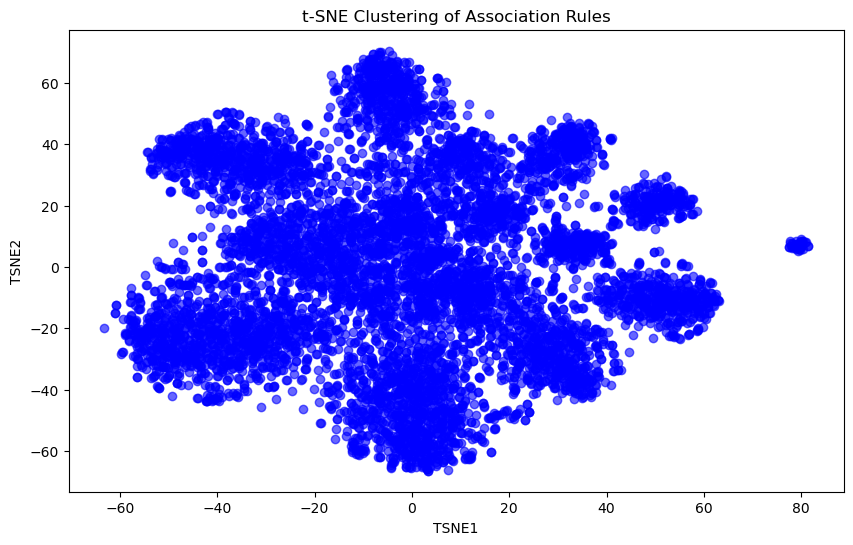

In [267]:
import matplotlib.pyplot as plt

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(data_tsne2['TSNE1'], data_tsne2['TSNE2'], c='blue', alpha=0.6)
plt.title('t-SNE Clustering of Association Rules')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

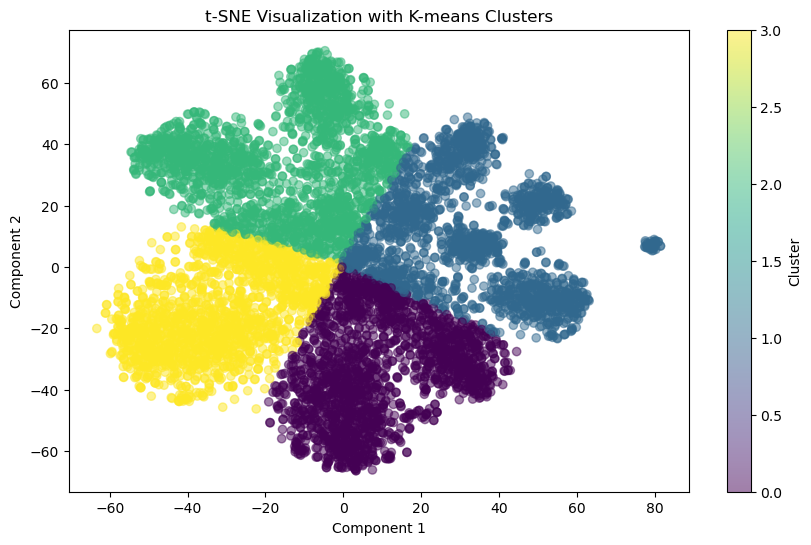

In [268]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4,init='k-means++', n_init=10, random_state=0)  # Change number of clusters as needed
clusters = kmeans.fit_predict(data_tsne2)

# Add cluster labels to the t-SNE DataFrame
data_tsne2['Cluster'] = clusters

# Plot the t-SNE result with clusters
plt.figure(figsize=(10, 6))
plt.scatter(data_tsne2['TSNE1'], data_tsne2['TSNE2'], c=data_tsne2['Cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.title('t-SNE Visualization with K-means Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [269]:
sm_cleaned5 = sm_cleaned.reset_index().drop(columns = 'chatter')
sm_cleaned5['tsne_clusters']=data_tsne['Cluster']
sm_cleaned5.set_index('Unnamed: 0', inplace = True)
sm_cleaned5

,current_events,travel,photo_sharing,tv_film,sports_fandom,politics,food,family,home_and_garden,music,...,beauty,parenting,dating,school,personal_fitness,fashion,small_business,spam,adult,tsne_clusters
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
hmjoe4g3k,0,2,2,1,1,0,4,1,2,0,...,0,1,1,0,11,0,0,0,0,3
clk1m5w8s,3,2,1,1,4,1,2,2,1,0,...,0,0,1,4,0,0,0,0,0,0
jcsovtak3,3,4,3,5,0,2,1,1,1,1,...,1,0,1,0,0,1,0,0,0,1
3oeb4hiln,5,2,2,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
fd75x1vgk,2,0,6,0,0,2,0,1,0,0,...,0,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
y3ijoqfgd,4,2,1,1,0,1,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
n6gud4ext,3,2,4,1,0,4,1,3,0,3,...,1,0,1,0,5,0,1,0,0,3
f71rt6cyg,2,1,1,4,1,2,1,0,3,0,...,0,1,1,0,6,1,0,0,0,3


In [270]:
#learning about clusters 
cluster0 = sm_cleaned5[sm_cleaned5['tsne_clusters']==0].drop(columns = 'tsne_clusters')
cluster1 = sm_cleaned5[sm_cleaned5['tsne_clusters']==1].drop(columns = 'tsne_clusters')
cluster2 = sm_cleaned5[sm_cleaned5['tsne_clusters']==2].drop(columns = 'tsne_clusters')
cluster3 = sm_cleaned5[sm_cleaned5['tsne_clusters']==3].drop(columns = 'tsne_clusters')

p1=cluster0.sum().sort_values(ascending = False)[:10]
p2=cluster0.mean().sort_values(ascending = False)[:10]

p3=cluster1.sum().sort_values(ascending = False)[:10]
p4=cluster1.mean().sort_values(ascending = False)[:10]

p5=cluster2.sum().sort_values(ascending = False)[:10]
p6=cluster2.mean().sort_values(ascending = False)[:10]

p7=cluster3.sum().sort_values(ascending = False)[:10]
p8=cluster3.mean().sort_values(ascending = False)[:10]

Number of points in Cluster 0 = 2006
Number of points in Cluster 1 = 1957
Number of points in Cluster 2 = 2147
Number of points in Cluster 3 = 1772


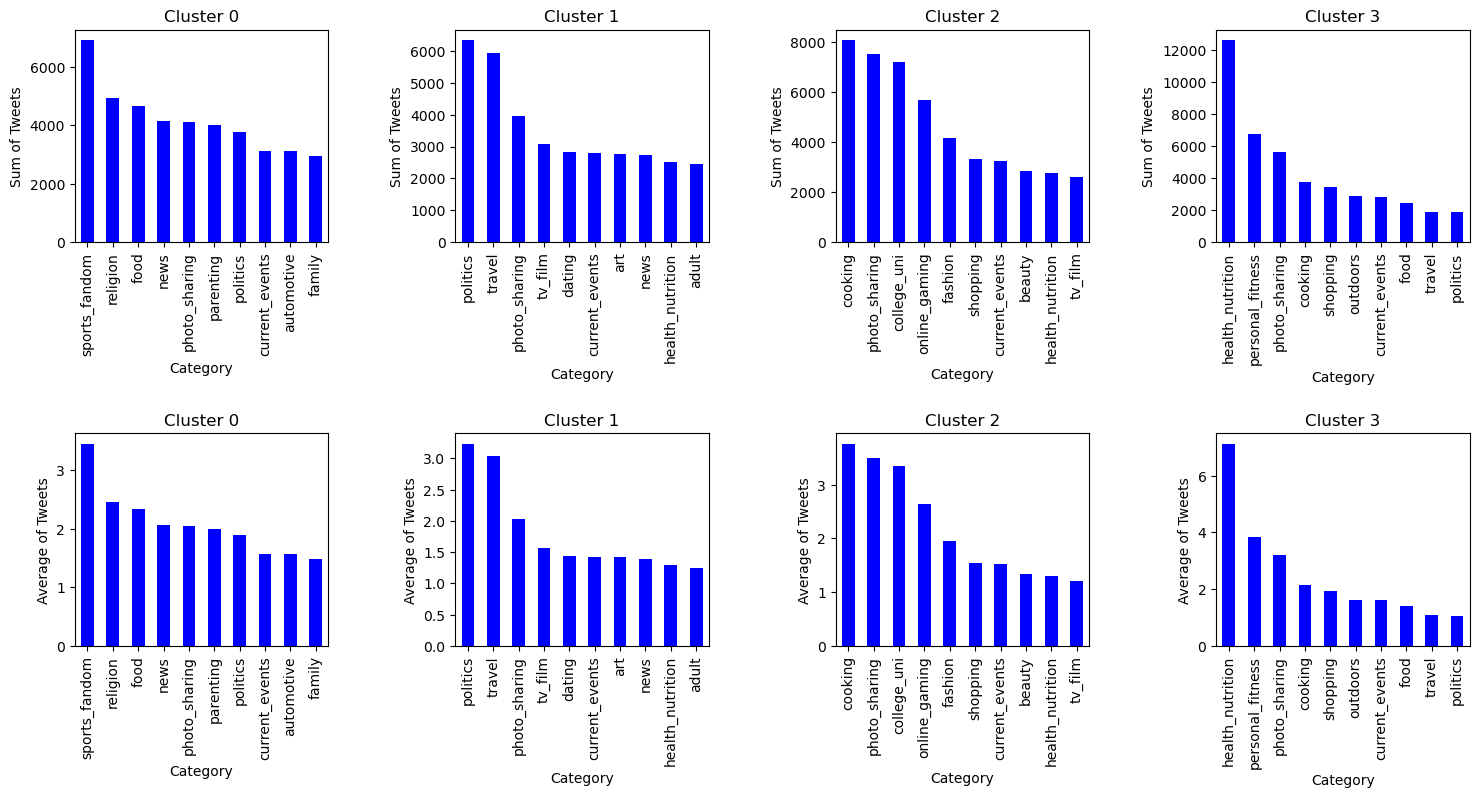

In [271]:
figure, axes = plt.subplots(nrows = 2, ncols = 4, sharex = False, sharey = False, figsize=(18, 8))

p1.plot(ax=axes[0, 0], title="Cluster 0", color="blue",linestyle='None',kind ='bar')
axes[0, 0].set_xlabel("Category")
axes[0, 0].set_ylabel("Sum of Tweets")
p2.plot(ax=axes[1, 0], title="Cluster 0", color="blue",linestyle='None',kind ='bar')
axes[1, 0].set_xlabel("Category")
axes[1, 0].set_ylabel("Average of Tweets")

p3.plot(ax=axes[0, 1], title="Cluster 1", color="blue",linestyle='None',kind ='bar')
axes[0, 1].set_xlabel("Category")
axes[0, 1].set_ylabel("Sum of Tweets")
p4.plot(ax=axes[1, 1], title="Cluster 1", color="blue",linestyle='None',kind ='bar')
axes[1, 1].set_xlabel("Category")
axes[1, 1].set_ylabel("Average of Tweets")

p5.plot(ax=axes[0, 2], title="Cluster 2", color="blue",linestyle='None',kind ='bar')
axes[0, 2].set_xlabel("Category")
axes[0, 2].set_ylabel("Sum of Tweets")
p6.plot(ax=axes[1, 2], title="Cluster 2", color="blue",linestyle='None',kind ='bar')
axes[1, 2].set_xlabel("Category")
axes[1, 2].set_ylabel("Average of Tweets")

p7.plot(ax=axes[0, 3], title="Cluster 3", color="blue",linestyle='None',kind ='bar')
axes[0, 3].set_xlabel("Category")
axes[0, 3].set_ylabel("Sum of Tweets")
p8.plot(ax=axes[1, 3], title="Cluster 3", color="blue",linestyle='None',kind ='bar')
axes[1, 3].set_xlabel("Category")
axes[1, 3].set_ylabel("Average of Tweets")

plt.subplots_adjust(hspace=0.9, wspace = 0.5)

print("Number of points in Cluster 0 =",len(cluster0))
print("Number of points in Cluster 1 =",len(cluster1))
print("Number of points in Cluster 2 =",len(cluster2))
print("Number of points in Cluster 3 =",len(cluster3))

The clusters seem to be really balanced compared to the one we got using just kmeans ++ <br>
**Cluster 0: The Athletic Insiders** : This cluster is primarily interested in sports, with strong engagements in news and religion. They might represent a group that is socially active and follows current events, with interests in family-oriented activities and food.<br>
**Cluster 1 : The Global Nomads** : Politically active and enjoys traveling. They are also engaged with entertainment (TV/film) and social activities like dating. They are likely well-informed and culturally curious.<br>
**Cluster 2: The Trendsetting Creativesy** : This cluster leans towards creativity and trendiness, with a strong interest in cooking, photography, gaming, and fashion. They may represent younger individuals, possibly students, who are highly engaged in digital activities and fashion.<br>
**Cluster 3: The Health Gurus** : This group is highly focused on health and fitness, with a significant interest in nutrition and personal fitness. They also engage with content around cooking, shopping, and outdoor activities. This cluster may represent individuals who prioritize healthy living. <br>

## Which clusters to choose ??

Both clusters are right and can be justified based on data and business purpose. <br>**Our results** : In reality, the slightly imbalanced clusters, like the one obtained using pure Kmeans++ (without chatter)creater more meaningful groups. These clusters show a clear separation between top interests and less significant ones, making it easier to understand what really drives each segment. <br>
This natural imbalance helps us focus on more targeted marketing. By honing in on the key characteristics of each group, we can design more effective campaigns and allocate resources where they’ll make the most impact. This approach helps us connect better with each customer segment and get more out of our marketing efforts.

## The final clusters

**Cluster Descriptions : Notice health_nutrition comes up as a important category in all of them**<br>
**Cluster 0 : College and University students- Social Enthusiasts**. With about 61%, this is the biggest cluster. They love photo sharing, current events, colleges and universities, shopping, travel, online gaming, sports, movies. Thier spending power might not be very high but they can be a very vital segment of the market for a health product - for its sales as well as marketing. <br>
**Cluster 1 Young adults - Politically Engaged Travelers**, kind of new to the workforce- accounting for just 8% of the total followers sample. They like to talk about politics, travel, news, sports , current events. They might be a small segment, but they would be having good spending power, coupled with the visibility for our product we talked about in the earlier segment<br>
**Cluster 2 -Health & Lifestyle Gurus** : These account for about 17% of our total followers. They are intrested in shopping, cooking, fashion, fitness, beauty and outdoors. They focus on a mix of health as well of lifestyle and fashion<br>
**Cluster 3 Community-Oriented Fans** (9 %) This cluster shows a strong interest in sports fandom, religion, and family-related topics. They seem to be deeply involved in their communities, whether through sports, religious activities, or family life. They have a strong connection to both recreational and community-focused activities.<br>
Note : We also tried clustering using just 3 clusters- there seemed to be some imbalance - with 1 cluser accounting for just spams and salcious content, the other 2 having interests in politics and travel and religion. We chose 4 based on the ch index, and optimal number of clsters that can be used to tailor the marketing campaigns